In [2]:
import pandas as pd
import folium as fl
from folium.plugins import HeatMap
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
data = pd.read_csv("aircraft-data_nov_dec.csv")

# **Data Wrangling**

In [4]:
#Correcting DataTypes
data.spotted = pd.to_datetime(data.spotted)
data.reg_expiration = pd.to_datetime(data.reg_expiration, format = '%m/%d/%y')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   flight          30915 non-null  object        
 1   tail_number     30947 non-null  object        
 2   long            30947 non-null  float64       
 3   lat             30947 non-null  float64       
 4   alt             30947 non-null  int64         
 5   manufacturer    30185 non-null  object        
 6   model           30185 non-null  object        
 7   reg_expiration  29958 non-null  datetime64[ns]
 8   reg_owner       30184 non-null  object        
 9   reg_city        30340 non-null  object        
 10  reg_state       30337 non-null  object        
 11  squawk          29053 non-null  float64       
 12  mph             30947 non-null  int64         
 13  spotted         30947 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(2), object(7)


/var/folders/xj/qwscmjj15k728nxqzq4pp9b40000gn/T/ipykernel_42699/4178018541.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.spotted = pd.to_datetime(data.spotted)


In [5]:
data.head()

,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted
0,SIS300,N300NJ,-118.213,34.5823,20175,BOMBARDIER INC,BD-100-1A10,2024-01-31,PUNTA PACIFICO I LLC,BAKERSFIELD,CALIFORNIA,1077.0,474,2022-11-07 13:30:00
1,UAL1434,N67501,-117.937,34.6038,36700,BOEING,737-9,2024-04-30,UNITED AIRLINES INC,CHICAGO,ILLINOIS,7730.0,523,2022-11-07 13:30:00
2,SWA3287,N483WN,-118.035,34.6345,13225,BOEING,737-7H4,2024-08-31,SOUTHWEST AIRLINES CO,DALLAS,TEXAS,4770.0,380,2022-11-07 13:30:00
3,AAL2059,N660AW,-118.075,34.4643,33750,AIRBUS INDUSTRIE,A320-232,2024-02-29,US BANK NA TRUSTEE,BOSTON,MASSACHUSETTS,1751.0,527,2022-11-07 13:30:00
4,N84PJ,N84PJ,-117.756,34.6002,34725,DASSAULT,FALCON 2000EX,2024-12-31,HAMPTON AIRWAYS INC,SELLERSBURG,INDIANA,6054.0,525,2022-11-07 13:40:00


In [6]:
#replacing all alternate names like AIRBUS INDUSTRIE, AIRBUS CANADA, etc. with AIRBUS
data.manufacturer = data.manufacturer.map(lambda x:'AIRBUS' if 'AIRBUS' in str(x) else x)

# **Feature Engineering**

In [7]:
#calculating number of flights per day
df_datecnt = data.spotted.dt.date.value_counts().reset_index().sort_values(by="spotted")

In [8]:
#adding an hour of the day column
data['hour'] = data.spotted.dt.hour
data.hour

0        13
1        13
2        13
3        13
4        13
         ..
30942    22
30943    22
30944    22
30945    22
30946    22
Name: hour, Length: 30947, dtype: int32

In [9]:
#Classification of Flights by altitude

df_alt = data[['alt']]
df_alt['alt_class'] = df_alt['alt'].apply(lambda x:
    'Private/Charter' if x <= 10000
    else 'Commercial' if (x > 10000 and x <= 40000)
    else 'Military'
)

df_alt.alt_class.value_counts()

/var/folders/xj/qwscmjj15k728nxqzq4pp9b40000gn/T/ipykernel_42699/1690669671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alt['alt_class'] = df_alt['alt'].apply(lambda x:


alt_class
Commercial         25206
Private/Charter     4256
Military            1485
Name: count, dtype: int64

# **Exploratory Data Analysis**

In [10]:
#HIGH AIR TRAFFIC ZONES IN THE FOCUS REGION
heat_data = data[['lat', 'long']].values

m = fl.Map(location=[data['lat'].mean(), data['long'].mean()], zoom_start=6)
HeatMap(heat_data, radius=8, blur=6, max_zoom=10).add_to(m)

m

In [11]:
#BUSIEST HOURS OF AIR TRAVEL
px.histogram(data.hour, x="hour").show()

<Axes: ylabel='count'>

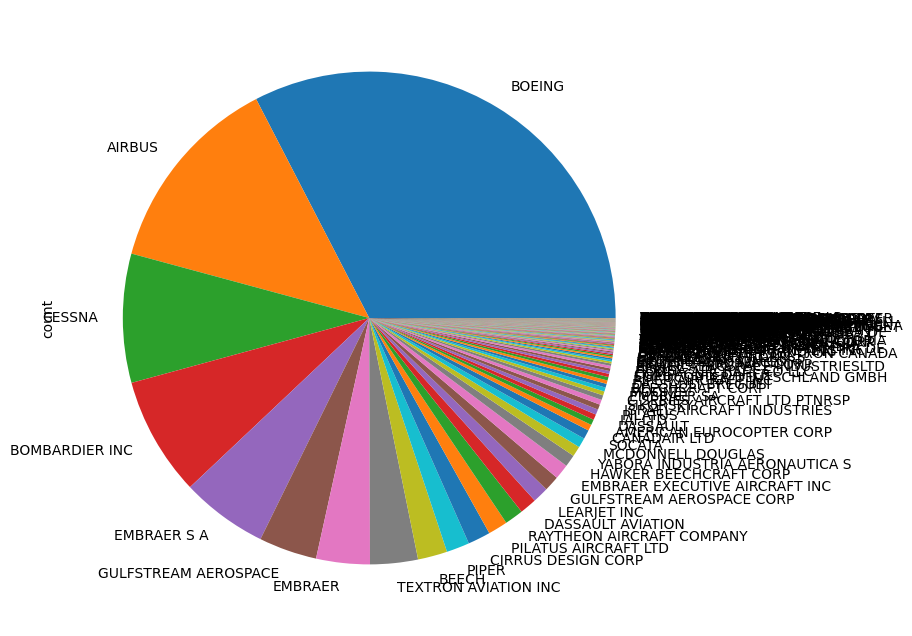

In [12]:
#NUMBER OF FLIGHTS BY AIRCRAFT MANUFACTURER
data.manufacturer.value_counts().plot.pie(y='manufacturer', figsize = (8, 8), )

In [13]:
data.manufacturer.value_counts().reset_index()

,manufacturer,count
0,BOEING,9837
1,AIRBUS,3985
2,CESSNA,2551
3,BOMBARDIER INC,2354
4,EMBRAER S A,1716
...,...,...
219,NEUFELD MARK WAYNE,1
220,VIKING AIR LIMITED,1
221,SHIPLE FRED J,1
222,FEATHERSTON LES W,1


In [14]:
#HIGHEST NUMBER OF FLIGHTS FLOWN WERE PRIVATE AND/ OR CHARTERED
px.bar(df_alt.alt_class.value_counts().reset_index(), x='alt_class', y='count', title='Most frequent Flight Type by Altitude').show()

# **Time Series Forecasting**

In [15]:
#TIME SERIES DISTRIBUTION OF FLIGHTS, DISPLAYING festive drops & no Seasonality
fig = px.line(df_datecnt, x='spotted', y='count', title='Daily Number of Flights Over Time', markers=True)
fig.show()

In [16]:
df_datecnt.spotted = pd.to_datetime(df_datecnt.spotted)
df_datecnt.reset_index(inplace=True)
df_datecnt.drop("index", axis=1, inplace=True)

In [17]:
#Using an Exponential Smoothing Model due to small dataset
model = ExponentialSmoothing(df_datecnt['count'], trend='additive', seasonal=None)
model_fit = model.fit()

In [18]:
#Forecasting for the next 10 days
forecast_days = 10
future_dates = pd.date_range(start=df_datecnt['spotted'].max() + pd.Timedelta(days=1), periods=forecast_days)
future_forecast = model_fit.forecast(forecast_days)


df_forecast = pd.DataFrame({'date': future_dates, 'count_of_flights_flown': future_forecast})
df_forecast.head()

,date,count_of_flights_flown
64,2023-01-10,354.275907
65,2023-01-11,349.913828
66,2023-01-12,345.551750
67,2023-01-13,341.189671
68,2023-01-14,336.827592


In [19]:
#Visualing the forecast against historical values
fig = px.line(df_datecnt, x='spotted', y='count', title='Exponential Smoothing Forecast')
fig.add_scatter(x=df_forecast['date'], y=df_forecast['count_of_flights_flown'], mode='lines+markers', name='Forecast')
fig.show()